In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

from explain.gradcam_heatmap_trajectories import compute_gradcam_and_pca, plot_heatmaps_per_label_and_component,plot_all_trajectories_with_and_without_heatmaps, compute_binned_heatmaps_per_label_and_component
from deep_traffic_generation.core.datasets import TrafficDataset
from sklearn.preprocessing import MinMaxScaler

# enable autoreload     
%load_ext autoreload    
%autoreload 2

In [8]:
# preparing the data
import pandas as pd
import numpy as np
dataset_name = "zurich_2019"
dataset = TrafficDataset.from_file(
        f"data/aircraft/{dataset_name}.parquet",
        features=["longitude", "latitude"],
        scaler=MinMaxScaler(feature_range=(-1, 1)),
        shape= "sequence",
        info_params={"features": ["latitude", "longitude"], "index": -1},
    )

In [9]:
# Save longitudes and latitudes in single file called data/lszh/positions.npy and labels too
# Dimensions should be (n_samples, seq_len, 2) and (n_samples)
positions = []
labels = dataset.labels
for flight, infos in dataset:
    positions.append(flight)

positions = np.array(positions)
labels = np.array(labels)
np.save(f'data/aircraft/positions.npy', positions)
np.save(f'data/aircraft/labels.npy', labels)
positions.shape, labels.shape

((900, 200, 2), (900,))

In [ ]:
# Define your parameters here
positions_path = 'data/aircraft/positions.npy'
labels_path = 'data/aircraft/labels.npy'

target_layer = 'encoder.0.layers.6'
device = 'cuda'  # or 'cuda' if you have a GPU

model_path = r'models\aircraft.ckpt'

In [11]:
import numpy as np
positions = np.load(positions_path, allow_pickle=True)
labels = np.load(labels_path, allow_pickle=True)
positions.shape, labels.shape

((900, 200, 2), (900,))

In [12]:
(dataset,
 labels,
 unique_labels,
 model,
 gradcam_projections,
 pca,
 positions_array,
 sample_labels) = compute_gradcam_and_pca(
     positions_path=positions_path,
     labels_path=labels_path,
     model_checkpoint_path=model_path,
     target_layer=target_layer,
     device=device,
     n_components=2
)

Positions shape: (900, 2, 200)
Labels shape: (900,)
Unique labels: ['East' 'South' 'West']
Computing Grad-CAM activations for all samples...


Grad-CAM Computation:   2%|▏         | 16/900 [00:04<03:53,  3.78it/s]


KeyboardInterrupt: 

In [10]:
(heatmaps_dict,
 (global_x_min, global_x_max),
 (global_y_min, global_y_max),
 global_min, global_max) = compute_binned_heatmaps_per_label_and_component(
     positions_array,
     gradcam_projections,
     sample_labels,
     unique_labels,
     n_components=2,
     grid_size=200,
     bin_stats='mean',
     sigma=5,
     norm=True
)

In [28]:
# Extract the heatmap for the first component and merge them for all labels
# For plotting in plot_dataset.npy
heatmaps = []
for label in unique_labels:
    heatmaps.append(heatmaps_dict[(label, 0)])
heatmaps = np.array(heatmaps)
heatmaps.shape

# Save the heatmaps
np.save('data/lszh/heatmaps.npy', heatmaps)

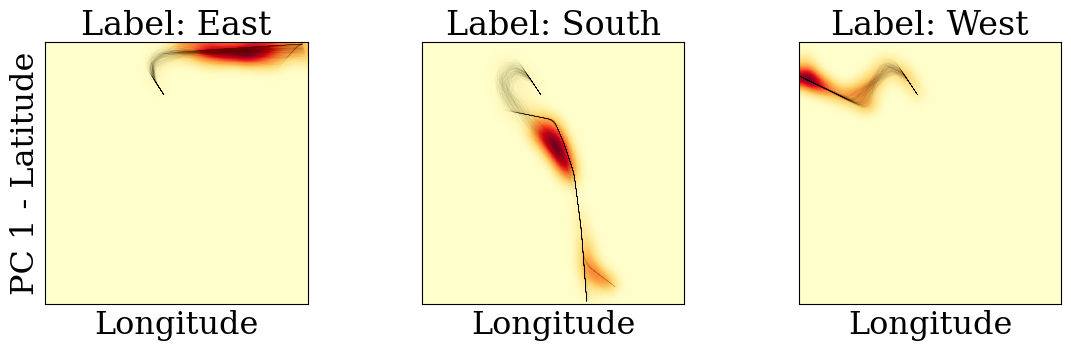

In [29]:
import matplotlib.pyplot as plt
fix = 12
plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX rendering
    "font.family": "serif",        # Use serif fonts
    "font.size": 11 + fix,               # Base font size
    "axes.titlesize": 12 + fix ,          # Titles slightly larger
    "axes.labelsize": 11 + fix,          # Axis labels size
    "xtick.labelsize": 11+ fix,         # Tick labels size
    "ytick.labelsize": 11+ fix,
    "legend.fontsize": 11+ fix,
})

plot_heatmaps_per_label_and_component(
    heatmaps_dict,
    positions_array,
    sample_labels,
    unique_labels,
    n_components=1,
    x_range=(global_x_min, global_x_max),
    y_range=(global_y_min, global_y_max),
    global_min=global_min,
    global_max=global_max,
    invert_y_axis=False,
    save_path='figures/lszh/heatmaps.png'
)


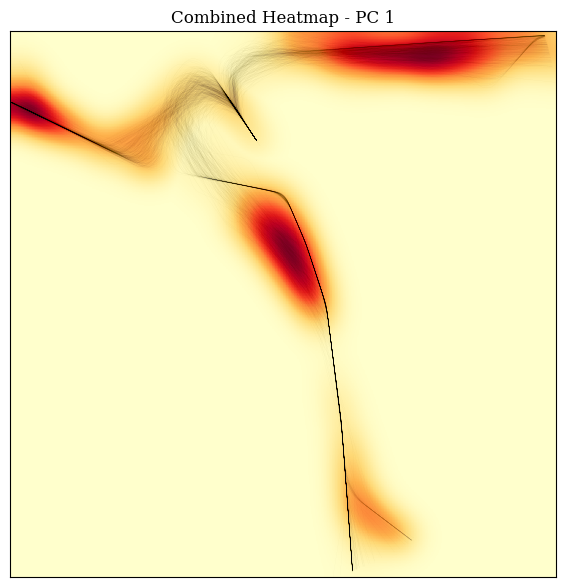

In [19]:
plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX rendering
    "font.family": "serif",        # Use serif fonts
    "font.size": 11,               # Base font size
    "axes.titlesize": 12,          # Titles slightly larger
    "axes.labelsize": 11,          # Axis labels size
    "xtick.labelsize": 11,         # Tick labels size
    "ytick.labelsize": 11,
    "legend.fontsize": 11,
})

plot_all_trajectories_with_and_without_heatmaps(
    heatmaps_dict,
    positions_array,
    sample_labels,
    unique_labels,
    n_components=1,
    x_range=(global_x_min, global_x_max),
    y_range=(global_y_min, global_y_max),
    global_min=global_min,
    global_max=global_max,
    invert_y_axis=False,
    concat_fun=np.maximum,
    show_trajectories=False
)
